# Soccer Analysis
the workflow of this notebook consists of the following:
   * Define the objective
   * Exploratory data analysis
   * Data visualization, and statistics summary
   * Feature engineering
   * Build a regression model
   * Predict all possible games with 32 teams
   * Simulate tournament for the 2018 world cup

In [1]:
import pandas as pd
matches = pd.read_csv('./data/matches.csv')
teams = pd.read_csv('./data/teams.csv')

In [2]:
matches.head()

,date,team1,team1Text,team2,team2Text,venue,IdCupSeason,CupName,team1Score,team2Score,statText,resText,team1PenScore,team2PenScore
0,19500308,WAL,Wales,NIR,Northern Ireland,"Cardiff, Wales",6,FIFA competition team qualification,0.0,0.0,NaN,0-0,NaN,NaN
1,19500402,ESP,Spain,POR,Portugal,"Madrid, Spain",6,FIFA competition team qualification,5.0,1.0,NaN,5-1,NaN,NaN
2,19500409,POR,Portugal,ESP,Spain,"Lisbon, Portugal",6,FIFA competition team qualification,2.0,2.0,NaN,2-2,NaN,NaN
3,19500415,SCO,Scotland,ENG,England,"Glasgow, Scotland",6,FIFA competition team qualification,0.0,1.0,NaN,0-1,NaN,NaN
4,19500624,BRA,Brazil,MEX,Mexico,"Rio De Janeiro, Brazil",7,FIFA competition team final,4.0,0.0,NaN,4-0,NaN,NaN


In [3]:
teams.head()

,confederation,name,fifa_code,ioc_code
0,CAF,Algeria,ALG,ALG
1,CAF,Angola,ANG,ANG
2,CAF,Benin,BEN,BEN
3,CAF,Botswana,BOT,BOT
4,CAF,Burkina Faso,BFA,BUR


In [4]:
set(matches['CupName'].values)

{'Confederation competition team final',
 'FIFA competition team final',
 'FIFA competition team qualification',
 'Friendly'}

In [5]:
# remove match duplicates 
matches = matches.drop_duplicates()
# modified date to datetime object with yyyy-mm-dd format
from datetime import datetime
matches['date'] = matches['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
matches.shape

(31825, 14)

So here we need some domain knowledge in soccer. If you frequently watch soccer games, you'll know that whether or not a team was playing at home would probably make a significant difference in its performance. Therefore, we want to take which team is playing at home into account. 

- We add two new variables to indicate whether or not the teams playing at home.
    - ```team1Home``` 
    - ```team2Home```
- If the first team is playing at home, then ```team1Home``` is ```True```, ```team2Home``` is ```False``` and vice versa.
- If both teams are playing at home, both ```team1Home``` and ```team2Home``` are ```True```; if both teams are away, then ```team1Home``` and ```team2Home``` are both ```False```. 

In [6]:
matches['team1Home'] = matches.apply(lambda x: str(x['team1Text'].lower() in str(x['venue']).lower()), axis=1)
matches['team2Home'] = matches.apply(lambda x: str(x['team2Text'].lower() in str(x['venue']).lower()), axis=1)
matches.head()

,date,team1,team1Text,team2,team2Text,venue,IdCupSeason,CupName,team1Score,team2Score,statText,resText,team1PenScore,team2PenScore,team1Home,team2Home
0,1950-03-08,WAL,Wales,NIR,Northern Ireland,"Cardiff, Wales",6,FIFA competition team qualification,0.0,0.0,NaN,0-0,NaN,NaN,True,False
1,1950-04-02,ESP,Spain,POR,Portugal,"Madrid, Spain",6,FIFA competition team qualification,5.0,1.0,NaN,5-1,NaN,NaN,True,False
2,1950-04-09,POR,Portugal,ESP,Spain,"Lisbon, Portugal",6,FIFA competition team qualification,2.0,2.0,NaN,2-2,NaN,NaN,True,False
3,1950-04-15,SCO,Scotland,ENG,England,"Glasgow, Scotland",6,FIFA competition team qualification,0.0,1.0,NaN,0-1,NaN,NaN,True,False
4,1950-06-24,BRA,Brazil,MEX,Mexico,"Rio De Janeiro, Brazil",7,FIFA competition team final,4.0,0.0,NaN,4-0,NaN,NaN,True,False


Also, another factor that might influence a team's performance is the type of matches it's playing. Normally, teams will treat Friendly match as an opportunity for exploring young talented players. Therefore, they would be less serious towards the scores. For the actual prediction, we might want to exclude the friendly matches if they turn out to make a huge difference. 

In [7]:
import copy
# make a deep copy for the matches including friendly matches 
matches_with_friendly = copy.deepcopy(matches)
# exclude the friendly matches for our analysis
matches = matches[matches['CupName'] != 'Friendly']
# also, we want to exclude the possible influence of outliers, like some
# teams would score more than 10 goals in a single match
matches = matches[(matches['team1Score']<=10) & (matches['team2Score']<=10)]
matches.shape

(13272, 16)

It turns out Friendly matches do occupy a significant portion of the total matches. Also, the data set needs to be further modified since a win for team 1 automatically means a loss for team 2. However, looking at an entry, it only reflects the result for a single team. Therefore, we should mirror each entry in another team's perspective, which means we could make a reverse version for every entry.

for example,
* team1 vs team2 
    * score - 1:3, team1Home - False, team2Home - True.
* team2 vs team1
    * score - 3:1, team1Home - True, team2Home - False

In [8]:
matches_mirror = copy.deepcopy(matches)

matches_mirror['team1'] = matches['team2']
matches_mirror['team2'] = matches['team1']

matches_mirror['team1Text'] = matches['team2Text']
matches_mirror['team2Text'] = matches['team1Text']

matches_mirror['team1Score'] = matches['team2Score']
matches_mirror['team2Score'] = matches['team1Score']

matches_mirror['team1Home'] = matches['team1Home']
matches_mirror['team2Home'] = matches['team2Home']

# concatenate the mirrored matches into the original matches data set
# to double up the number of entries
matches = pd.concat([matches, matches_mirror])
matches.shape

(26544, 16)

#### now the data-preprocessing is almost ready, we just want to take a look of a few rows


In [9]:
matches.sort_values(by='date')
matches.head()

,date,team1,team1Text,team2,team2Text,venue,IdCupSeason,CupName,team1Score,team2Score,statText,resText,team1PenScore,team2PenScore,team1Home,team2Home
0,1950-03-08,WAL,Wales,NIR,Northern Ireland,"Cardiff, Wales",6,FIFA competition team qualification,0.0,0.0,NaN,0-0,NaN,NaN,True,False
1,1950-04-02,ESP,Spain,POR,Portugal,"Madrid, Spain",6,FIFA competition team qualification,5.0,1.0,NaN,5-1,NaN,NaN,True,False
2,1950-04-09,POR,Portugal,ESP,Spain,"Lisbon, Portugal",6,FIFA competition team qualification,2.0,2.0,NaN,2-2,NaN,NaN,True,False
3,1950-04-15,SCO,Scotland,ENG,England,"Glasgow, Scotland",6,FIFA competition team qualification,0.0,1.0,NaN,0-1,NaN,NaN,True,False
4,1950-06-24,BRA,Brazil,MEX,Mexico,"Rio De Janeiro, Brazil",7,FIFA competition team final,4.0,0.0,NaN,4-0,NaN,NaN,True,False


### Statistical Analysis 


#### Year of the Match vs Total Goals for the Match

In [10]:
### extract year from date variable 
matches['year'] = matches['date'].apply(lambda x: x[:4])
### extract the total scores by summing up team1Score and team2Score
matches['totalScores'] = matches['team1Score'] + matches['team2Score']

/Users/Nelson/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


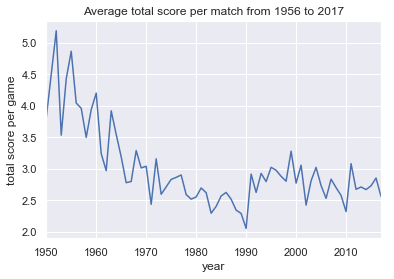

In [11]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline 

### group the matches by year 
year_vs_score = matches.groupby('year').mean()
year_vs_score = year_vs_score.reset_index()[['year', 'totalScores']]
year_vs_score['subject'] = 0

### make a time-series plot
ax = sns.tsplot(data=year_vs_score, time='year', value='totalScores', unit='subject')
ax.set_title('Average total score per match from 1956 to 2017', fontsize=12)
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('total score per game', fontsize=12)
plt.show()

### Winning Percentage 
- we can observe from the time series plot that the average total scores per game has been dropping till 1990. After that, we see a solid increase. This makes sense, because now teams put more effort in defense rather than attack, leading to rarer scoring opportunities. 
- next, we want to look at the winning percentage for each team, with and without friendly matches.

In [12]:
matches.index = range(len(matches))

def win_pct(matches):
    ### create a dictionary to store the total number
    ### of games and number of winnings for each team
    win_pct_teams = dict()
    
    for i in matches.index:
        team1 = matches.loc[i, 'team1']
        team2 = matches.loc[i, 'team2']
        score1 = matches.loc[i, 'team1Score']
        score2 = matches.loc[i, 'team2Score']
        
        ### for every entry, we have information about 
        ### two teams. 
        ### Update information for team 1
        if team1 in win_pct_teams:
            win_pct_teams[team1]['total_matches'] += 1
            if score1 > score2:
                win_pct_teams[team1]['win_matches'] += 1
        else:
            if score1 > score2:
                win_pct_teams[team1] = {'total_matches':1, 'win_matches':1}
            else:
                win_pct_teams[team1] = {'total_matches':1, 'win_matches':0}
                
        ### update information for team 2
        if team2 in win_pct_teams:
            win_pct_teams[team2]['total_matches'] += 1
            if score2 > score1:
                win_pct_teams[team2]['win_matches'] += 1
        else:
            if score2 > score1:
                win_pct_teams[team2] = {'total_matches':1, 'win_matches':1} 
            else:
                win_pct_teams[team2] = {'total_matches':1, 'win_matches':0}
                
    win_pct_info = list()
                
    ### convert dictionary into a list 
    for k,v in win_pct_teams.items():
        win_pct_info.append((k, v['total_matches'], v['win_matches'], 
                             v['win_matches'] / v['total_matches']))
        
    ### convert dictionary into a dataframe
    import pandas as pd
    win_df = pd.DataFrame(win_pct_info, columns=['team_name', 'total_matches', 
                                                 'win_matches', 'win_pct'])
    
    return win_df[win_df['total_matches'] >= 10]
        

In [25]:
### no friendly matches 
df_no_friendly = win_pct(matches)
### with friendly matches
df_friendly = win_pct(matches_with_friendly)

In [31]:
df_no_friendly.head(3)

,team_name,total_matches,win_matches,win_pct
0,WAL,314,98,0.312102
1,NIR,338,104,0.307692
2,ESP,604,350,0.579470


#### visualize winning percentage 

In [60]:
def visualize_win_pct(df, title):
    x = df['total_matches']
    y = df['win_pct']
    n = df['team_name']
        
    import matplotlib.pyplot as plt
    %matplotlib inline 
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('total matches', fontsize=13)
    ax.set_ylabel('win pct', fontsize=13)
    
    fig.set_size_inches(16, 8)

    ### draw a horizontal line to indicate 50% winning percentage 
    plt.axhline(y=0.5, xmin=0, xmax=1000, linewidth=2, color='y')
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]))

KeyError: 65

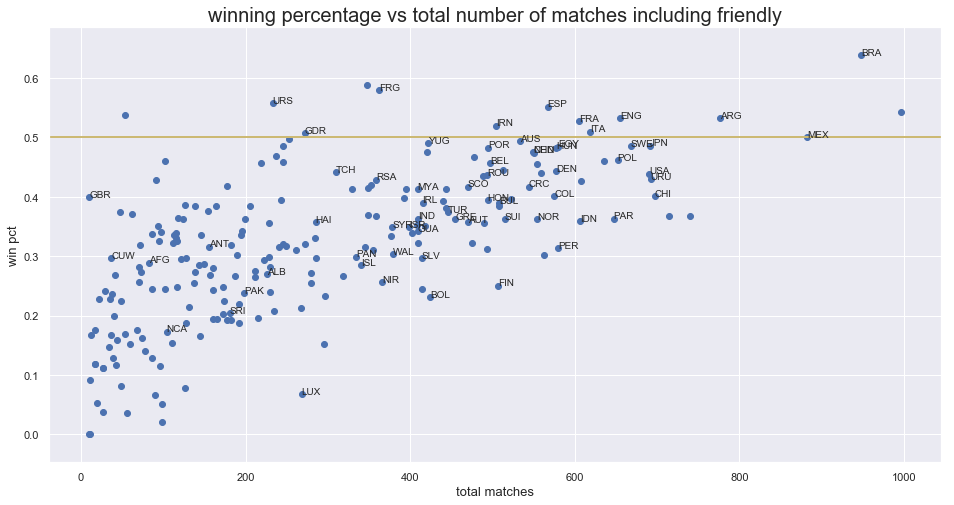

In [59]:
visualize_win_pct(df_friendly, 'winning percentage vs total number of matches including friendly')

KeyError: 38

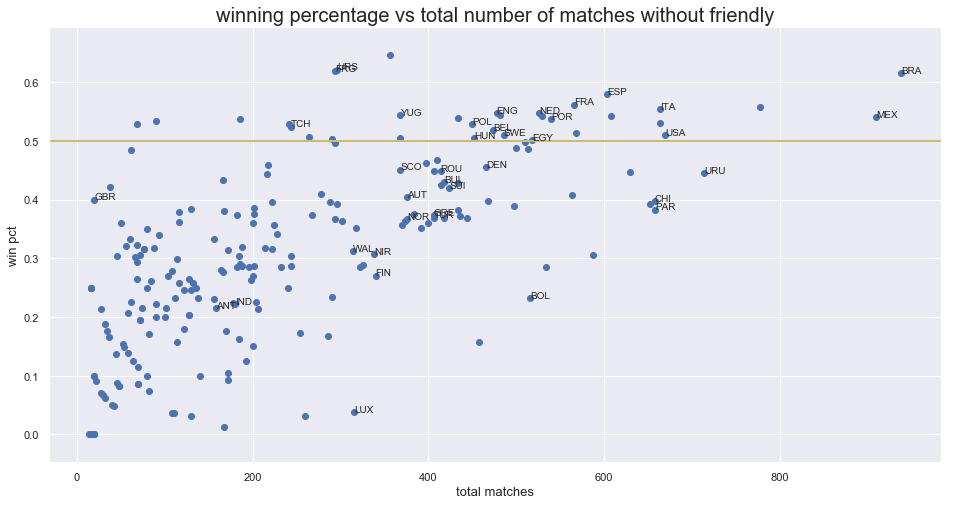

In [29]:
visualize_win_pct(df_no_friendly, 'winning percentage vs total number of matches without friendly')

#### a couple of observations
* with or without friendly matches, Brazil played a lot of matches, and it gets the highest winning percentage.
* Korea (KOR) has been playing a significant amount friendly matches. 
* Some teams has very high winning percentage, like Japan (JPN), Korea (KOR), but actually played poorly in the previous world cups, why?